# Compression Anonymity

This notebook explores several avenues of using compression and common compression schemes to provide anonymity and privacy. First, we'll write a simple implementation of Huffman encoding, but make it generic enough so that it can be tweaked to provide privacy instead of compression.

# Preliminaries

Before writing any code for privacy, we'll need the basic data structures and building blocks we're going to use throughout this notebook to write the compression algorithms.

## Setup

In [1]:
:ext RebindableSyntax
:ext NoImplicitPrelude
:opt svg

import Privacy.Prelude

default (Natural, Integer, Word, Int, Ratio Natural, Rational, Double)

## Algebras

We'll rely on three main concepts to generalize the compression algorithms.

### Information

When anonymizing information, we'll need a general way to talk about the "information" a set contains. This is well represented by an information algebra: it's similar to a measure on a set, but has fewer constraints. We'll represent it here as a simple function:

In [2]:
type Information a b = a -> b

The simplest type of "information" is the number of elements a set contains. (the "counting" measure)

In [3]:
:ext GeneralizedNewtypeDeriving

import Graphics.Rendering.Chart.Plot.Bars (BarsPlotValue)
import Graphics.Rendering.Chart.Axis.Types (PlotValue)

newtype Count
    = Count
    { getCount :: Natural
    } deriving (Eq,Ord,NaturalLiteral,PlotValue,BarsPlotValue)
    
instance Show Count where
    showsPrec n (Count x) = showsPrec n x

count :: Information a Count
count _ = Count 1

Two useful other notions of information are ranges:

In [4]:
data Range a
    = Range
    { lowerBound :: a
    , upperBound :: a
    } deriving (Eq, Ord)

range :: Information a (Range a)
range x = Range x x

instance (Show a, Eq a) => Show (Range a) where
    show (Range lb ub)
        | lb == ub = show lb 
        | otherwise = "[" ++ show lb ++ "," ++ show ub ++ "]"

instance NaturalLiteral a => NaturalLiteral (Range a) where
    fromNatural = range . fromNatural

And the set of unique elements:

In [5]:
import Data.Set (Set)
import qualified Data.Set as Set

elements :: Information a (Set a)
elements = Set.singleton

### Semirings

When manipulating information, we'll often want to generalize and focus on information. These ideas are neatly encapsulated by a "semirig".

Semirigs go by several different definitions in the literature: here we'll only require 2 operations. "Generalization" is a union-like operation, which we'll call $+$; "refinement" is an intersection-like operation, which we can call $\times$. They include the usual associativity and distributivity laws.

In [6]:
instance Semirig Count where
    (+) = (+) `ala` getCount
    (*) = (*) `ala` getCount

instance Ord a => Semirig (Range a) where
    Range xl xu + Range yl yu = Range (min xl yl) (max xu yu)
    Range xl xu * Range yl yu = Range (max xl yl) (min xu yu)

instance Ord a => Semirig (Set a) where
    (+) = Set.union
    (*) = Set.intersection

Using these, we can generalize sets of values to their information:

In [10]:
:ext TypeApplications
:ext DataKinds

generalizeTo count (nonEmpty @ [1,2,3,4,5])

5

In [12]:
generalizeTo range (nonEmpty @ [4,2,1,3,5])

[1,5]

Using these types we can generate a histogram:

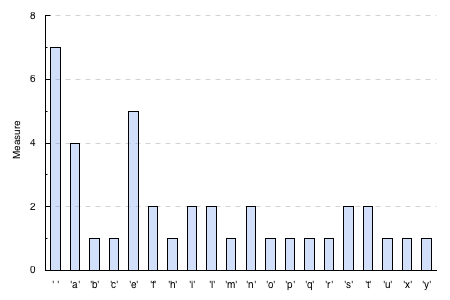

In [13]:
import Algebra.Information.Histogram

generalizeTo
    (histogramOf count)
    (nonEmptyString @ "this is an example of a frequency table")

We'll display histograms of continuous data slightly differently:

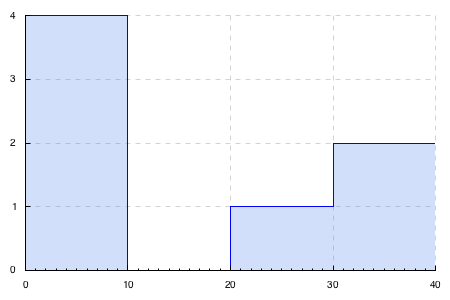

In [14]:
import Graphics.Rendering.Chart.Plot.Histogram.Simple

contHist 10 0 [6,2,3,1,36,38,27]

### Measures

In order to compare the "weight" of one information to another, we'll need a way to order them.

In [21]:
import Data.Functor.Contravariant

rangeSize :: (Semirig a, Ord a) => Comparison (Range a)
rangeSize
    = Comparison
        (\(Range xl xu) (Range yl yu) -> compare (xu + yl) (yu + xl))

smaller :: Comparison a -> a -> a -> Bool
smaller (Comparison cmp) x y = cmp x y == LT

smaller rangeSize (3 + 4) (1 + 5)

lte :: Comparison a -> a -> a -> Bool
lte (Comparison cmp) x y = cmp x y /= GT

lte rangeSize (1 + 5) (1 + 5)
lte rangeSize (1 + 6) (1 + 5)

True

True

False

We can also have an ordering for diversity:

In [23]:
diversity :: Comparison (Set a)
diversity = Comparison (comparing Set.size)

smaller diversity
    (generalizeTo elements nonEmpty @ []) 
    (generalizeTo elements no[])

True

## A Binary Tree

This is the tree we'll use for both the encoding and anonymization algorithms. It caches some measure of its subtrees: this could be their diversity, the amount of information they contain, or simply the number of elements.

In [ ]:
import Algebra.Information.Tree

-- :info Tree

We can draw the tree, with the measures of subtrees at each node:

In [ ]:
Node 5 (Leaf 3 'a') (Node 2 (Leaf 1 'b') (Leaf 1 'c')) :: Tree Count Char

Then, we'll need some machinery for translating between codes and trees.

In [ ]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map
import           Algebra.Information.Huffman

foldMapWithCode :: Semigroup m => (Code -> b -> m) -> Tree a b -> m
foldMapWithCode f (Leaf _ x) = f (Code []) x
foldMapWithCode f (Node _ xs ys)
    =  foldMapWithCode (f . (Code #. (:) False .# getCode)) xs
    <> foldMapWithCode (f . (Code #. (:) True  .# getCode)) ys

codeBook :: Ord b => Tree a b -> Map b Code
codeBook = foldMapWithCode (flip Map.singleton)

## A Priority Queue

A pairing heap <cite data-cite="2201627/9H95638W"></cite> is simple to implement, and works well as a priority queue. Both the `<>` and `insertHeap` functions below are amortized $\mathcal{O}(1)$, and `minView` is amortized $\mathcal{O}(\log n)$.

In [ ]:
data Heap a b = Heap a b [Heap a b]

instance Ord a => Semigroup (Heap a b) where
    Heap i x xs <> Heap j y ys
      | i <= j = Heap i x (Heap j y ys : xs)
      | otherwise = Heap j y (Heap i x xs : ys)

minView :: Ord a => Heap a b -> (a, b, Maybe (Heap a b))
minView (Heap i x xs) = (i, x, case xs of
    [] -> Nothing
    (y:ys) -> Just (mergeHeaps y ys))
  where
    mergeHeaps t []          = t
    mergeHeaps t1 [t2]       = t1 <> t2
    mergeHeaps t1 (t2:t3:ts) = (t1 <> t2) <> mergeHeaps t3 ts

insertHeap :: Ord a => a -> b -> Heap a b -> Heap a b
insertHeap i x (Heap j y ys)
  | i <= j = Heap i x [Heap j y ys]
  | otherwise = Heap j y (Heap i x [] : ys)

# Huffman Encoding

We're now able to write the algorithm for Huffman compression.

In [ ]:
:ext FlexibleContexts
:ext DataKinds

import           Data.Maybe       (fromJust)
import           Data.Map.Strict  (Map)
import qualified Data.Map.Strict  as Map
import           IHaskell.Display (Display(..),html)

import qualified Text.Blaze.Html5 as Tag
import qualified Text.Blaze.Html5.Attributes as Attr
import           Text.Html.Table
import           GHC.Exts (fromString)

buildHuffman :: Ord (f a) => (f a -> f a -> f a) -> Heap (f a) (Tree f a) -> Tree f a
buildHuffman (<+>) hp = case minView hp of
    (_,x,Nothing) -> x
    (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i <+> j) x y
        (j,y,Just ys) ->
            buildHuffman (<+>) (insertHeap (i <+> j) (Node (i <+> j) x y) ys)

buildHeap :: Ord (f a) => Histogram f a -> Heap (f a) (Tree f a)
buildHeap
    = fromJust
    . getOption
    . Map.foldMapWithKey (\v i -> Option (Just (Heap i (Leaf i v) [])))
    . getMeasures

huffmanTree :: (Ord a, Information f a)
            => [a] -> Tree f a
huffmanTree = buildHuffman (+) . buildHeap . generalize

tree = huffmanTree "this is an example of a huffman tree"
    :: Tree Count Char
tree

import Algebra.Information.Huffman

huffmanEncode :: Ord a => Tree c a -> [a] -> Table [a, Code]
huffmanEncode tr xs =
    table ("Original", "Code")
          (Attr.style (fromString "text-align: center;")
          ,Attr.style (fromString "text-align: left;"))
          [(x, mp Map.! x) | x <- xs ]
  where
    mp = codeBook tr

huffmanEncode tree "example"

## Huffman Anonymity

Huffman compression has a ready analogue in the form of $k$-anonymity <cite data-cite="2201627/S5ZJQFX5"></cite>. By truncating the output of the Huffman compression, rows which occur fewer than $k$ times are not specified: instead, a prefix (which could correspond to some $n$ rows, $n \geq k$) is provided.

Taken from a different perspective, we build a Huffman tree from the rows in our database. Then, for each value in the database, we walk down the tree from root to the corresponding leaf, stopping if we hit a node that contains fewer than $k$ entries. Then, we output the summary of values at that point.

This general procedure forms the basis for several of the anonymization algorithms.

First, for data, let's use ages:

In [ ]:
ages :: [Int]
ages = [5,15,19,22,25,33,33,39,31,44,41,42,48,55,59,70]

agesTree = huffmanTree ages :: Tree Count Int
agesTree

Finally, we can draw the tree in its private form.

In [ ]:
:ext TypeApplications

privateTree @ Range (>=2) agesTree

Ages are grouped together with values that are unrelated, yielding unsatisfactory generalizations. The anonymization produced is as follows:

In [ ]:
:ext RecordWildCards

import qualified Data.Map.Strict         as Map
import           Data.Semigroup          (Semigroup(..))
import           Data.Semigroup.Foldable (foldMap1)
import           Data.Foldable           (foldl')
import           IHaskell.Display        (IHaskellDisplay(display)
                                         ,html,Display)
import           Text.Printf             (printf)
import           Control.Applicative
import           Control.Monad
import Data.Functor.Identity

anonMapping :: (Ord a, Information g a)
            => (f a -> Bool) -> Tree f a -> Histogram g a
anonMapping reveal = Histogram . fromJust . (anonTree $ \tr -> do
    guard (reveal (measure tr)) 
    let sm = generalize tr
    pure (foldMap (\v -> Map.singleton v sm) tr))
    
anonTree :: (Alternative f, Semigroup c) => (Tree a b -> f c) -> Tree a b -> f c
anonTree select tr@(Node i l r) = liftA2 (<>) (anonTree select l) (anonTree select r)
                               <|> select tr
anonTree select tr = select tr

anonTable :: (Applicative m,Ord a
             ,Information f a,Show a)
          => (f a -> m String)
          -> Histogram f a
          -> [a]
          -> m (Table [a, String])
anonTable output (Histogram mapping) xs
    = fmap toTable (traverse (\x -> output (mapping Map.! x)) xs)
  where
    toTable strs
        = table ("Original", "Anonymized")
                (Attr.style (fromString "text-align: center;")
                ,Attr.style (fromString "text-align: center;"))
                (zip xs strs)

anonTablePure :: (Information f a, Ord a, Show a, Show (f a))
              => Histogram f a
              -> [a]
              -> Table [a, String]
anonTablePure hist = runIdentity #. anonTable (pure #. show) hist

anonTablePure @ Range (anonMapping (2<=) agesTree) ages

Better generalizations can be achieved by building an *alphabetic* Huffman tree <cite data-cite="2201627/M35JL7I9"></cite>.

In [ ]:
import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))

import qualified Prelude as Num

buildAlphHuffman :: Histogram Count a -> Tree Count a
buildAlphHuffman xs = evalState (go c) (Map.toList (getMeasures xs))
  where
    c = getCount (getGeneralization (foldMap Generalization (getMeasures xs)))
    go n = do
      (x,Count i) <- gets head
      if i >= n
        then do
          modify tail
          pure (Leaf (Count i) x)
        else do
          let m = n `div` 2
          ls <- go m
          let nxt = n Prelude.- (getCount (measure ls))
          if nxt <= 0 then pure ls else do
            rs <- go nxt
            pure (Node (measure ls + measure rs) ls rs)

alphHuffmanTree :: Ord a => [a] -> Tree Count a
alphHuffmanTree = buildAlphHuffman . generalize

k2agesAlph = privateTree @ Range (2<=) (alphHuffmanTree ages)
k2agesAlph

anonTablePure @ Range (anonMapping (2<=) (alphHuffmanTree ages)) ages

# Arithmetic Coding for Privacy

Arithmetic coding compresses data by encoding successively smaller and smaller intervals. For our purposes, it has two properties which are desirable:

* It is a streaming algorithm, able to output the encoding for an input symbol once it has been received.
* It parameterizes the notion of a "model": for compression, this allows intelligent prediction of things like "a u is likely to come after a q" (when compressing English text). Commonly, it facilitates the building of a frequency table on the fly. For our purposes, it will both build the frequency table on-the-fly, and potentially allow us to cluster similar data together.

In order to use the algorithm for privacy, we will first emit a sequence of intervals, instead of a single number. This removes the capacity for compression. For instance, for the letters $a,b,c$, the following might be emitted:

$$\frac{1}{3},\frac{1}{3},\frac{1}{3}$$

Secondly, we will use a model that builds a cumulative frequency table on the fly (e.g. with a Fenwick tree). This widens the interval for more frequently occurring symbols.

Thirdly, we will truncate the output of the representation of each interval. In other words, we will widen every interval. The amount we widen by will be the minimum amount to make the interval larger than $\frac{k}{n}$ where $n$ is the number of symbols seen so far.

Finally, we will decompress as we compress, translating the intervals back into the values of the domain we are anonymizing. Because we have truncated the interval, it may span more than one value in our model. This is desired: it will happen only when $k$ is satisfied only through generalization.

As a simple way to demonstrate the algorithm, we will use a perfect binary tree to count the cumulative frequencies:

In [ ]:
:ext TypeSynonymInstances
:ext FlexibleInstances

import           Data.Bits
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Rose
import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           Data.Maybe                (catMaybes,fromJust)

data Nested a
    = Perfect !a
    | Nest !(Nested (Branch a))

type Perfect = Nested ()

foldPerfect :: (Word -> b -> Word -> b -> b) -> b -> Perfect -> b
foldPerfect f = go f . const
  where
    go :: (Word -> b -> Word -> b -> b) -> (a -> b) -> Nested a -> b
    go _ b (Perfect x) = b x
    go f b (Nest t) = go f (\(Branch ls l rs r) -> f ls (b l) rs (b r)) t

data Branch a =
    Branch {-# UNPACK #-} !Word
           !a
           {-# UNPACK #-} !Word
           !a

data Span = Span {-# UNPACK #-} !Word {-# UNPACK #-} !Word

instance Show Span where
    showsPrec n (Span l 0) = showsPrec n l
    showsPrec _ (Span l o)
        = showChar '['
        . shows (shiftL l (fromEnum o))
        . showChar ','
        . shows (shiftL (l + 1) (fromEnum o))
        . showChar ')'

makePerfect :: Word -> Perfect
makePerfect = mk ()
  where
    mk :: a -> Word -> Nested a
    mk x 0 = Perfect x
    mk x m = Nest (mk (Branch 0 x 0 x) (pred m))

incr :: Word -> Perfect -> Perfect
incr i tr = go i 0 tr id
  where
    go :: Word -> Word -> Nested a -> (a -> a) -> Nested a
    go _ _ (Perfect x) c = Perfect (c x)
    go i p (Nest t) c =
        Nest $
        go i (p + 1) t $
            \(Branch sl l sr r) ->
              if testBit i (fromEnum p)
                then Branch sl l (sr + 1) (c r)
                else Branch (sl + 1) (c l) sr r

instance IHaskellDisplay Perfect where
    display = display
            . diagram
            . drawTree
            . res
            . foldPerfect toTree []
      where
        toTree x l y r = [Rose.Node x l, Rose.Node y r]
        res xs = Rose.Node (sum (map Rose.rootLabel xs)) xs
        drawTree
            = pad 1.1
            . centerXY
            . renderTree
                (\n -> text (show n) # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white)
                (~~)
            . symmLayout
                
foldr incr (makePerfect 3) [0,3,3,2,6]

Then, we can write a function that looks up an item in the tree *up until* the point where $k$ is no longer satisfied:

In [ ]:
follow :: Int -> Word -> Perfect -> Span
follow k' i tr = foldPerfect go Span tr 0 k
  where
    k = toEnum k'
    go sl lt sr rt l p
      | sl < k || sr < k = Span l p
      | testBit i (pred (fromEnum p)) = rt (shiftL l 1 .|. 1) (pred p)
      | otherwise = lt (shiftL l 1) (pred p)

The advantage of this approach is that it maintains $k$-anonymity incrementally. Take, for instance, this small list of values between $0$ and $4$:

In [ ]:
smallVals = [1,2,1,3,2,0,1,0,3]

import Data.Traversable (mapAccumL)
import Data.List        (inits)

incrementalAnon :: Int -> Word -> [Word] -> [[Span]]
incrementalAnon k sz xs
    = snd 
    $ mapAccumL
        anon
        (makePerfect sz)
        (zip xs (tail (inits xs)))
  where
    anon tr (v,vs) = (i,traverse (follow k) vs i)
      where
        i = incr v tr

mapM_ print (incrementalAnon 2 2 [1,2,1,3,2,0,1,0,3])

# Incremental Anonymity

Incrementally anonymizing a database can potentially leak private data <cite data-cite="2201627/HWXFFBRT"></cite>. For instance, take the following values:

In [ ]:
anonTablePure @ Range (anonMapping (2<=) (alphHuffmanTree [1..5])) [1..5]

If another $3$ is added to the database:

In [ ]:
anonTablePure @ Range (anonMapping (2<=) (alphHuffmanTree [1,2,3,4,5,3])) [1,2,3,4,5,3]

If both of these anonymizations are released, we could take their row-wise intersection, thereby revealing much more information than we intended.

In [ ]:
intersection = anonMapping (2<=) (alphHuffmanTree [1..5])
             * anonMapping (2<=) (alphHuffmanTree [1,2,3,4,5,3])

anonTablePure @ Range intersection [1..5]

The solution might seem simple: just don't change the anonymization of previous entries. But this is actually sub-optimal, leaving earlier more conservative than they need to be.

The problem is related to *tree-balancing*. For search trees, we want to balance to reduce search cost, but reduce the frequency of balancing to reduce insertion cost: here, we want to balance to increase information gain, but reduce frequency of balancing to avoid revealing private internal structure.

It's worth noting that we're not concerned with the overall frequency of balances, rather the rebalancing per release. After all, if we only release one copy of the anonymized data set, we need not be concerned with incremental privacy at all.

# Generalized Balance

In the previous section, we saw that we could generalize the "cost of rebalancing" to describe incremental anonymity. Other notions from the theory of search trees can be generalized similarly, in particular *balance*.

One generalization applies to $l$-diversity <cite data-cite="2201627/E9354EJL"></cite>.

Let's take a database with a sensitive row, perhaps voting preference:

In [ ]:
:ext TypeOperators

import Control.Arrow ((***))
import Text.Printf   (PrintfArg(..),formatChar)

data VotingPref
    = D
    | R
    deriving (Show,Eq,Ord,Enum,Bounded)

instance Tag.ToMarkup VotingPref where
    toMarkup D = Tag.toMarkup 'D'
    toMarkup R = Tag.toMarkup 'R'

instance (Tag.ToMarkup a, Tag.ToMarkup b) => Tag.ToMarkup (a,b) where
    toMarkup (x,y) = Tag.toMarkup '('
                  <> Tag.toMarkup x
                  <> Tag.toMarkup ','
                  <> Tag.toMarkup y
                  <> Tag.toMarkup ')'

agesAndVotes = zip ages [D,R,D,D,R,D,R,R,R,R,D,D,R,R,D,D]
privateTree @ Range (2<=) (alphHuffmanTree agesAndVotes)
anonTablePure @ Range (anonMapping (2<=) (alphHuffmanTree agesAndVotes)) agesAndVotes

As you can see, while $k$-anonymity has indeed been preserved, most rows in the table have had their voting preference revealed. To counteract that, we can balance the voting preference when building the tree: however, this ups the complexity of the procedure.

# Randomization

Providing an equivalence class for each $k$-anonymous value is problematic in 2 ways:

* It allows an adversary to intersect the members of this class with future releases, revealing more information that originally intended.
* It doesn't provide distribution information on the members of the class.

While we could remedy the second point by providing a histogram instead of a set, but that would exacerbate the problem of the first.

Instead, we can randomize the output from the tree traversal, providing a concrete value that may have noise added in the output. This will allow us to output a representative table, with the distributions similar to the private table, but also it will hide the equivalence groupings we use in the tree, allowing us to aggressively rebalance when necessary.

This concept maps on to group differential privacy.

The idea is as follows: for every row, we're going to choose one bit to replace with a fairly chosen representative of that bit, based on the histogram of the table. The $\epsilon$ (of $\epsilon$-differential privacy) is given by the difference in size of the two branches, over the sum in the size of the two branches. For instance, in the following table:

In [ ]:
table = "aabbbcdee"

simpleTree = huffmanTree table :: Tree Count Char
simpleTree
huffmanEncode simpleTree table

Replacing the last bit in the first 'b' with a histogram would provide:

$$\epsilon = \frac{3-2}{3+2}$$

$\epsilon$-differential privacy. However, since it's from a subset of the database of size $5$, there are going to be $5$ differentially private queries on that subset. So, it would actually only provide:

$$\epsilon = \frac{1}{5^2}$$

$\epsilon$-differential privacy.

For every row in the database, we can replace one bit with its histogram representation: the equation above gives the privacy provided by replacing that bit. Obviously, the privacy provided by replacing later bits is much greater than that of earlier.

In [ ]:
import Data.Ratio    ((%))
import Data.Function (on)

diff :: Count a -> Count a -> Count a
diff (Count x) (Count y)
  | x >= y = Count (x Prelude.- y)
  | otherwise = Count (y Prelude.- x)

diffPrivacy :: Tree Count a -> Rational
diffPrivacy (Node (Count i) l r)
    = toInteger (getCount (diff (measure l) (measure r))) % toInteger (i * i)
diffPrivacy (Leaf _ _) = 0

To use this for releasing private information, we will first need to have a way to generate a random bit from a histogram:

In [ ]:
:ext StandaloneDeriving

import System.Random       (RandomGen, randomR, getStdRandom, Random(..))
import Control.Monad.State (StateT, state, runState, runStateT)
import Data.Bool           (bool)

instance Random (Count a) where
    randomR (lo,hi) g = case randomR (toInteger lo, toInteger hi) g of
        (res,g') -> (fromInteger res, g')
    random g = case random g of
        (res,g') -> (fromInteger (abs res), g')

choose :: (RandomGen g, Applicative m, Monoid a, Random a, Ord a)
       => a -> a -> StateT g m Bool
choose f t = StateT (\g -> case randomR (mempty, f `mappend` t) g of
  (n,g') -> pure (f < n,g'))

getStdRandom (runState (replicateM 10 (bool '0' '1' <$> choose 1 1)))

Then, we'll need to be able to randomly choose an item from a histogram (represented as a tree):

In [ ]:
select :: (RandomGen g, Monad m, Monoid b, Random b, Ord b) => Tree b a -> StateT g m a
select (Leaf _ x) = pure x
select (Node _ l r) = choose (measure l) (measure r)
                  >>= bool (select l) (select r)

In [ ]:
import Data.Bool (bool)

subtrees :: [Bool] -> Tree b a -> [Tree b a]
subtrees = foldr f b where
  b = (:[])
  f side acc tr = tr : case tr of
    Leaf _ _ -> []
    Node _ l r -> acc (bool l r side)

last :: Foldable f => f a -> Maybe a
last = foldl (const Just) Nothing

diffAnonymize :: RandomGen g
              => Rational
              -> [Bool]
              -> Tree (Count a) a
              -> Maybe (State g a)
diffAnonymize eps xs
    = fmap select
    . last
    . filter (\st -> diffPrivacy st > eps)
    . subtrees xs

randAnon :: (Ord a, RandomGen g) => Rational -> [a] -> Maybe (State g [a])
randAnon k xs = sequence <$> traverse (\x -> diffAnonymize k (mp Map.! x) tr) xs
  where
    tr = alphHuffmanTree xs
    mp = codeBook tr

import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution

randVar :: IO Double
randVar = withSystemRandom (genContVar (normalDistr 40 5) `asTypeOf`
                            const (undefined :: IO Double))

randAges <- filter (0<) <$> replicateM 100 randVar
anonRandAges <- getStdRandom (runState (fromJust (randAnon 0 randAges)))

randAges == anonRandAges

In [ ]:
histogram 2 10 randAges
histogram 2 10 anonRandAges

# Full Generalization

In [ ]:
data AnonymizationScheme a b c d e m f
    = AnonymizationScheme
    { build :: [a] -> Tree b a
    , mappg :: c -> Tree b a -> f d
    , run   :: d -> m e
    }

anonymize :: (Applicative f, Alternative f, Semigroup d, Applicative m) => AnonymizationScheme a b c d e m f -> c -> [a] -> f (m [e])
anonymize = undefined